## Гиперпараметры обучения нейронной сети

- Количество слоев нейронной сети
- Количество нейронов в каждом слое
- Функции активации, которые используются в слоях
- Тип оптимизатора при обучении нейронной сети
- Количество эпох обучения

Установка Keras Tuner

In [ ]:
pip install -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 6.8 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
from google.colab import files
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
import numpy as np

<ipython-input-2-89a0e12add9e>:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization


## Подготовка данных для обучения сети

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train / 255
x_test = x_test / 255
y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)

## Задаем функцию создания нейронной сети

In [ ]:
def build_model(hp):
    model = Sequential()
    activation_choice = hp.Choice('activation', values=['relu', 'sigmoid', 'tanh', 'elu', 'selu'])
    model.add(Dense(units=hp.Int('units_input',    # Полносвязный слой с разным количеством нейронов на входном слое
                                   min_value=16,   # минимальное количество нейронов - 16
                                   max_value=32,   # максимальное количество - 32
                                   step=4),        # шаг проверки нейронов
                    input_dim=784,
                    activation=activation_choice)) # Выбираем функцию активации из предложенных 5
    model.add(Dense(units=hp.Int('units_hidden',   # Кол-во нейронов на скрытом слое
                                   min_value=8,
                                   max_value=24,
                                   step=4),
                    activation=activation_choice))
    model.add(Dense(10, activation='softmax'))     # функция активации
    model.compile(                                 # функция созд модели
        optimizer=hp.Choice('optimizer', values=['adam','rmsprop','SGD']), # выбор оптимизаторов из 3 предложенных
        loss='categorical_crossentropy',           # ошибка
        metrics=['accuracy'])                      # метрика точности
    return model

- ReLU. Функция проста для вычисления и имеет производную, равную либо 1, либо 0.
- Elu. Эта функция активации устраняет некоторые проблемы с ReLU и сохраняет некоторые положительные моменты. Для этой функции активации выбирается альфа-значение; общее значение составляет от 0,1 до 0,3.
- Selu. Масштабная экспоненциальная линейная единица. Эта функция активации является одной из новых, и она служит нам в особенно длинном приложении (90 страниц) с теоремами, доказательствами и т. Д.
- Сигмоиды применяются в нейронных сетях в качестве функций активации. Они позволяют нейронам как усиливать слабые сигналы, так и не насыщаться от сильных сигналов.
- Функция активации "связывает" слой взвешенных сумм объектов с последующим слоем значений данных объектов. Гиперболический тангенс.

- Стохастический градиентный спуск (SGD) — это простой, но очень эффективный подход к подгонке линейных классификаторов и регрессоров под выпуклые функции потерь
- RMSProp. Знаменатель есть корень из среднего квадратов градиентов, отсюда RMSProp — root mean square propagation
- Adam — один из самых эффективных алгоритмов оптимизации в обучении нейронных сетей. Он сочетает в себе идеи RMSProp и оптимизатора импульса.

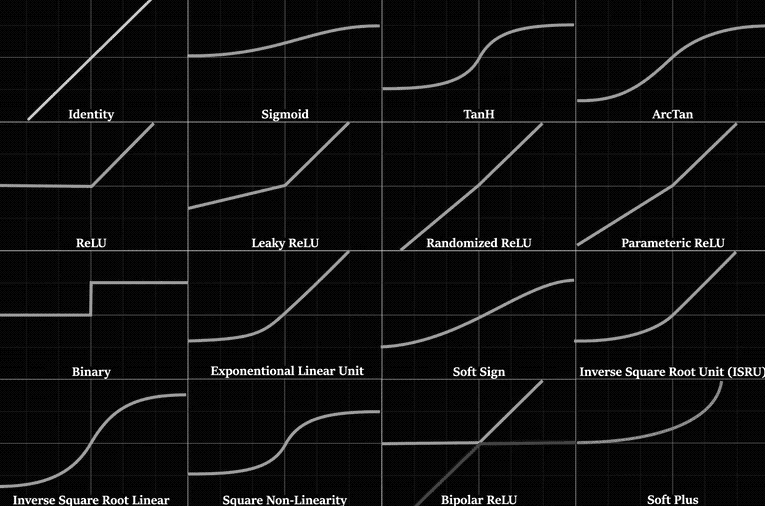

## Создаем tuner

Доступные типы тюнеров:
- RandomSearch - случайный поиск.
- Hyperband - алгоритм оптимизации на основе многорукого бандита, Li, Lisha, and Kevin Jamieson.
- BayesianOptimization - байесовская оптимизация

In [ ]:
tuner = RandomSearch(
    build_model,                 # функция создания модели
    objective='val_accuracy',    # метрика, которую нужно оптимизировать -
                                 # доля правильных ответов на проверочном наборе данных
    max_trials=25,               # максимальное количество запусков обучения
    directory='test_directory'   # каталог, куда сохраняются обученные сети
    )

## Запускаем подбор гиперпараметров

Пространство поиска

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh', 'elu', 'selu'], 'ordered': False}
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 32, 'step': 4, 'sampling': 'linear'}
units_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 24, 'step': 4, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'SGD'], 'ordered': False}


Подбор гиперпараметров

In [ ]:
tuner.search(x_train,                  # Данные для обучения
             y_train,                  # Правильные ответы
             batch_size=256,           # Размер мини-выборки
             epochs=10,                # Количество эпох обучения
             validation_split=0.2,     # Часть данных, которая будет использоваться для проверки (%)
             )

Trial 25 Complete [00h 00m 10s]
val_accuracy: 0.8544166684150696

Best val_accuracy So Far: 0.8679999709129333
Total elapsed time: 00h 04m 39s


## Выбираем лучшую модель

In [ ]:
tuner.results_summary()

Results summary
Results in test_directory/untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
activation: tanh
units_input: 20
units_hidden: 20
optimizer: rmsprop
Score: 0.8679999709129333

Trial 04 summary
Hyperparameters:
activation: tanh
units_input: 28
units_hidden: 20
optimizer: rmsprop
Score: 0.8675833344459534

Trial 02 summary
Hyperparameters:
activation: relu
units_input: 32
units_hidden: 12
optimizer: adam
Score: 0.8673333525657654

Trial 06 summary
Hyperparameters:
activation: elu
units_input: 24
units_hidden: 24
optimizer: adam
Score: 0.8651666641235352

Trial 11 summary
Hyperparameters:
activation: selu
units_input: 28
units_hidden: 16
optimizer: rmsprop
Score: 0.8638333082199097

Trial 22 summary
Hyperparameters:
activation: elu
units_input: 16
units_hidden: 16
optimizer: adam
Score: 0.8619999885559082

Trial 19 summary
Hyperparameters:
activation: elu
units_input: 32
units_hidden: 8
optimizer: rmsprop

Получаем три лучших модели

In [ ]:
models = tuner.get_best_models(num_models=3)

Оцениваем качество модели на тестовых данных

In [ ]:
for model in models:
  model.summary()
  model.evaluate(x_test, y_test) #оценка по набору данных, которые не использовались в обучении
  print()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                15700     
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
Total params: 16,330
Trainable params: 16,330
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 1s 2ms/step - loss: 0.4032 - accuracy: 0.8581

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 28)                21980     
        